In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import ensemble, preprocessing, model_selection, impute, datasets

In [2]:
# 以波士顿放假为例
boston = datasets.load_boston()

In [3]:
boston.data.shape

(506, 13)

In [5]:
X, y = boston.data, boston.target
n_samples, n_features = boston.data.shape

In [9]:
# 为完整的数据放入缺失值
# 首先确定我们希望放入缺失数据的比例，这里我们假设为50%，那么总共就要有506 * 13 * 0.5个数据缺失
rng = np.random.RandomState(30)
missing_rate = 0.5
# floor向下取整，返回一个浮点数  np.floor(1.6) => 1.0
n_missing_samples = int(np.floor(n_features * n_samples * missing_rate))

In [10]:
n_missing_samples

3289

In [11]:
# 在所有数据要随机分布在数据集中的各行各列中，而缺失的数据会需要一个行索引和一个列索引
# 如果我们能创造一个数组，包含3289个分布在0~506中间的行索引，和3289个分布在0~13之间列索引，那我们就可以
# 利用索引为数据中任意3289个位置赋空值
# 最后我们用0 均值和随机森林来填写缺失值，然后查看回归结果如何

missing_features = rng.randint(0, n_features, n_missing_samples)
missing_samples = rng.randint(0, n_samples, n_missing_samples)

In [12]:
missing_features

array([ 5,  5,  4, ...,  5, 11,  9])

In [14]:
# 我们现在采样了3289个数据，远远超过我们的样本量506个，所以我们使用随机抽样randint。当如果我们需要
# 的数据量小于我们的样本量，那我们就可以采用np.random.choice来抽样，choice会随机抽取不重复的随机数，
# 因此可以帮助我们让数据更分散，确保数据不会集中在一些行中

# 随机从0~10中抽取3个数，后面还可以设置p参数来设置权重
np.random.choice(10, 3)

array([4, 9, 5])

In [18]:
X_missing = X.copy()
y_missing = y.copy()

In [19]:
X_missing[missing_samples, missing_features] = np.nan
X_missing = pd.DataFrame(X_missing)
X_missing.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,NaN,2.31,NaN,0.538,6.575,65.2,NaN,NaN,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,NaN,NaN,4.9671,2.0,242.0,17.8,396.90,NaN
2,0.02729,NaN,NaN,0.0,NaN,7.185,61.1,4.9671,NaN,NaN,17.8,NaN,4.03
3,0.03237,0.0,NaN,0.0,NaN,6.998,45.8,6.0622,3.0,222.0,NaN,394.63,2.94
4,0.06905,NaN,NaN,0.0,0.458,NaN,NaN,6.0622,3.0,222.0,18.7,396.90,NaN


In [26]:
X_missing.isnull().mean()

0     0.369565
1     0.393281
2     0.389328
3     0.436759
4     0.377470
5     0.351779
6     0.407115
7     0.387352
8     0.401186
9     0.403162
10    0.381423
11    0.397233
12    0.428854
dtype: float64

In [27]:
X_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
0     319 non-null float64
1     307 non-null float64
2     309 non-null float64
3     285 non-null float64
4     315 non-null float64
5     328 non-null float64
6     300 non-null float64
7     310 non-null float64
8     303 non-null float64
9     302 non-null float64
10    313 non-null float64
11    305 non-null float64
12    289 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


In [22]:
# 使用0和均值填补缺失值
# 使用均值填充缺失值
imp_mean = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
X_missing_mean = imp_mean.fit_transform(X_missing)
X_missing_mean

array([[3.44777000e+00, 1.12003257e+01, 2.31000000e+00, ...,
        1.53000000e+01, 3.96900000e+02, 4.98000000e+00],
       [2.73100000e-02, 0.00000000e+00, 7.07000000e+00, ...,
        1.78000000e+01, 3.96900000e+02, 1.28904844e+01],
       [2.72900000e-02, 1.12003257e+01, 1.07714887e+01, ...,
        1.78000000e+01, 3.57944525e+02, 4.03000000e+00],
       ...,
       [6.07600000e-02, 0.00000000e+00, 1.07714887e+01, ...,
        2.10000000e+01, 3.96900000e+02, 5.64000000e+00],
       [1.09590000e-01, 0.00000000e+00, 1.19300000e+01, ...,
        2.10000000e+01, 3.93450000e+02, 6.48000000e+00],
       [3.44777000e+00, 1.12003257e+01, 1.19300000e+01, ...,
        2.10000000e+01, 3.96900000e+02, 1.28904844e+01]])

In [23]:
# 使用0进行填补
imp_zero = impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
X_missing_zero = imp_zero.fit_transform(X_missing)
X_missing_zero = pd.DataFrame(X_missing_zero)
X_missing_zero

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00000,0.0,2.31,0.0,0.538,6.575,65.2,0.0000,0.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,0.000,0.0,4.9671,2.0,242.0,17.8,396.90,0.00
2,0.02729,0.0,0.00,0.0,0.000,7.185,61.1,4.9671,0.0,0.0,17.8,0.00,4.03
3,0.03237,0.0,0.00,0.0,0.000,6.998,45.8,6.0622,3.0,222.0,0.0,394.63,2.94
4,0.06905,0.0,0.00,0.0,0.458,0.000,0.0,6.0622,3.0,222.0,18.7,396.90,0.00
5,0.02985,0.0,2.18,0.0,0.000,6.430,0.0,0.0000,0.0,222.0,18.7,0.00,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,0.00,12.43
7,0.14455,12.5,0.00,0.0,0.000,0.000,0.0,5.9505,5.0,0.0,15.2,0.00,19.15
8,0.21124,0.0,7.87,0.0,0.524,5.631,100.0,0.0000,5.0,0.0,15.2,386.63,29.93
9,0.00000,0.0,7.87,0.0,0.000,6.004,85.9,0.0000,0.0,311.0,0.0,386.71,17.10


In [30]:
# 最后使用随机森林回归进行填补缺失值
# 因为特征列与标签列存在某种关系，所以我们才能进行预测
# 换个思维考虑一下，我把含有缺失值的那一列当做标签列，把剩下的特征列和原来的标签列当做特征，利用新的标签列中已有的值
# 训练数据，而那些缺失值利用预测进行填补，对于我们这样含有大量缺失值的数据，需要我们遍历所有的特征，
# 从缺失值最少的开始进行填补，在填补这个特征时，需要先将其他特征缺失值用0代替
X_missing_reg = X_missing.copy()
# 缺失值的统计
X_missing_reg.isnull().sum(axis=0)

0     187
1     199
2     197
3     221
4     191
5     178
6     206
7     196
8     203
9     204
10    193
11    201
12    217
dtype: int64

In [32]:
# 因为我
sorted(X_missing_reg.isnull().sum(axis=0))

[178, 187, 191, 193, 196, 197, 199, 201, 203, 204, 206, 217, 221]

In [33]:
# 按对应值大小的索引进行输出
np.argsort(X_missing_reg.isnull().sum(axis=0))

0      5
1      0
2      4
3     10
4      7
5      2
6      1
7     11
8      8
9      9
10     6
11    12
12     3
dtype: int64

In [37]:
[*X_missing_reg.columns]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [39]:
ser = pd.Series([5, 6, np.NaN])
ser

0    5.0
1    6.0
2    NaN
dtype: float64

In [42]:
~ser.isna()

0     True
1     True
2    False
dtype: bool

In [48]:
X_missing_reg = X_missing.copy()
sort_index = np.argsort(X_missing_reg.isnull().sum(axis=0))
for i in sort_index:
    df = X_missing_reg
    # 取出缺失值最少的当做新的标签列
    new_y = df.iloc[:, i]
    new_x = df.iloc[:, df.columns != i]
    new_x = pd.concat([new_x, pd.DataFrame(y)], axis=1)
#     print('new_x', type(new_x))
#     print('new_y', type(new_y))

    # 对新特征列缺失值用0进行填补
    imp = impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
    new_x = imp.fit_transform(new_x)
    
    # 新标签的训练集和测试集
    new_y_train = new_y[new_y.notna()]
    new_y_test = new_y[new_y.isna()]
#     print('new_x', type(new_x))
#     print('new_y_train', type(new_y_train))
    
    # 新特征列的训练集和测试集
    new_x_train = new_x[new_y_train.index, :]
    new_x_test = new_x[new_y_test.index, :]
    
    # 建立模型，开始训练 预测
    rfr = ensemble.RandomForestRegressor(n_estimators=100, n_jobs=-1).fit(new_x_train, new_y_train)
    pred = rfr.predict(new_x_test)
    
    # 使用预测值进行填充
    X_missing_reg.loc[X_missing_reg.iloc[:, i].isnull(), i]= pred
    
    

In [50]:
# 对所有的数据进行建模，取MSE结果
X_all = [X, X_missing_mean, X_missing_zero, X_missing_reg]
mse = []
std = []
for x in X_all:
    estimator = ensemble.RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=30)
    mean_mse = model_selection.cross_val_score(estimator, x, y, scoring='neg_mean_squared_error',cv=10).mean()
    mse.append(-1 * mean_mse)
mse

[21.463270204274497, 38.67998050486274, 42.75456054098039, 19.260035206431382]

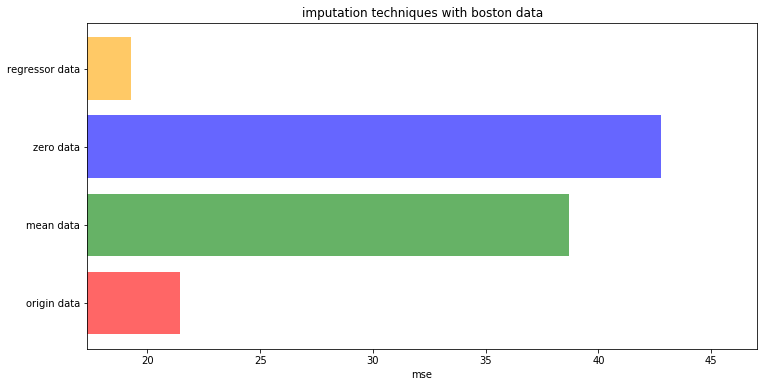

In [55]:
x_labels = ['origin data', 'mean data', 'zero data', 'regressor data']
colors = ['r', 'g', 'b', 'orange']
plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
for i in np.arange(len(mse)):
    ax.barh(i, mse[i], color=colors[i], alpha=0.6, align='center')
ax.set_title('imputation techniques with boston data')
ax.set_xlim(left=min(mse) * 0.9, right=max(mse) * 1.1)
# 设置y轴上显示4个刻度线
ax.set_yticks(np.arange(len(mse)))
# 设置刻度线上显示的标签
ax.set_yticklabels(x_labels)
ax.set_xlabel('mse')
plt.show()